### drifting the periodically force Harper model?

In [1]:
import numpy as np

import matplotlib.pyplot as plt
from scipy.integrate import odeint
import mpmath as mpmath

# %matplotlib notebook 
%matplotlib inline 

import Husimi   # Quantum routines
import Harp     # Classical integration routines
import importlib  # for reloading routines if you need to edit them

### issues:

We need to also write a routine that drifts the classical system smoothly and explore that too. 

In [36]:
importlib.reload(Husimi)  # if you need to reload it!

<module 'Husimi' from '/Users/aquillen/Desktop/summer24/pylab/QI_explore/Husimi.py'>

In [38]:
importlib.reload(Harp)  # if you need to reload it!

<module 'Harp' from '/Users/aquillen/Desktop/summer24/pylab/QI_explore/Harp.py'>

In [32]:

# this routine must be fixed, exp is not a matrix op!

# compute the propagator U across tau = (0 to 2 pi) 
# allowing time dependent variations during Trotterization
#  arguments:
#     N      : size of discrete quantum space
#     ntau   : how many Trotterized steps to take
#     parms0 = [a,b,eps,mu,mup]      : parameters of classical model, all unitless, 
#         at tau=0
#     d_parms = the rate of change in these parameters w.r.t tau.  parms = parms0 + tau*d_parms
#   Here tau ranges from 0 to 2pi so parms0 is value at the beginning of the period
#  returns:
#    Ufinal  : The propagator hat U_T  (NxN complex matrix)
#    w       : vector of eigenvalues of U in order of increasing phase (or quasienergy)
#    vr      : vector of associated eigenfunctions of U
#        vr[:,j] is the eigenvector with eigenvalue w[j]

def U_prop2_var(N,ntau,parms0,d_parms):
    shift_by_pi = 0.
    taushift = 0.0 # could become a free parameter to pass
      
    DLambda_B =np.zeros((N,N),dtype=complex)  # storing diagonal matrix for phi part
    Efac = N/ntau    # Bohr Sommerfeld type quantization gives this
    # this is L_0/hbar x 2pi/ntau = N/2pi x 2pi/ntau = N/ntau, is correct , includes dtau

    #diagonals  used in construction 
    Dc= np.zeros(N,dtype=complex)
    Ds= np.zeros(N,dtype=complex)
    
    dtau = 2*np.pi/ntau  # step size for tau
    
    Q_FT,Q_FT_dagger = Husimi.QFT(N)  # need only be computed once, Fourier transform matrices

    #create some diagonals ahead of time, these are 1d arrays
    kvec = np.arange(N)  #integers from 0 to N-1
    pkvec = 2*np.pi*kvec/N  # frequencies or angles 
    Dc = np.cos(pkvec)
    Ds = np.sin(pkvec)
    phivec = pkvec # is the same thing really giving 2*np*j/N
    
    # half step at the beginning
    parms = parms0 + d_parms*taushift
    a = parms[0];  b = parms[1] 
    D_Ah = np.diag(np.exp(-0.5j*Efac*a*(1.0 - Dc*np.cos(b) - Ds*np.sin(b)))) # exp works on each element of the array  
    # this is going to be equal to a(1-cos(hat p - b)), note that cos (p-b) = cos p cos b + sin p sin b
    # we contruct a matrix from a 1d array using numpy.diag()
    # is a half step because of 0.5  
    LAh  = np.matmul(Q_FT,np.matmul(D_Ah ,Q_FT_dagger)) # now go back into phi basis 
    
    U_final = LAh;  # half step at the beginning
        
    for i in range(ntau): # each dtau
        tau = i*dtau + taushift # time of propagator 
        parms = parms0 + d_parms*tau # parameters at each time!
        a = parms[0] # note the order of the parameter list, these are current parameters
        b = parms[1]
        eps = parms[2]
        mu =  parms[3]
        mup =  parms[4]
        # full step, this is a*(1- cos (p-b)), because of -1
        D_A = np.diag(np.exp(-1j*Efac*a*(1.0 - Dc*np.cos(b) - Ds*np.sin(b)))) # create a diagonal matrix 
        LA = np.matmul(Q_FT,np.matmul(D_A ,Q_FT_dagger)) #FT into phi basis 

        # create the diagonal 
        D_B_diag = np.exp(1j*Efac*(eps*np.cos(phivec) + mu*np.cos(phivec-tau) + mup*np.cos(phivec+tau)))
        # note sign of 1j (-1 * -1 = 1), 1=fullstep
        DLambda_B = np.diag(D_B_diag) # create a matrix now from the diagonal 
            
        U_final = np.matmul(LA,np.matmul(DLambda_B,U_final)) # mult by B and then A, full steps

    parms = parms0 + d_parms*(taushift + 2*np.pi - dtau)
    a = parms[0];  b = parms[1]   
    # is a half inverse step because of 0.5  
    D_Ah_inv = np.diag(np.exp(0.5j*Efac*a*(1.0-Dc*np.cos(b) - Ds*np.sin(b)))) # is a matrix
    LAh_inv     = np.matmul(Q_FT,np.matmul(D_Ah_inv ,Q_FT_dagger)) # now go back into phi basis 
    # apply inverse half step 
    U_final = np.matmul(LAh_inv,U_final)
    
    (w,vr)=np.linalg.eig(U_final)  # get eigenvalues and eigenvectors
    w_s,vr_s = Husimi.esort_phase(w,vr)   # sort in order of increasing eigenvalue phase
    return w_s,vr_s,U_final

    # this was tested with routine that does not drift during to make sure we computed a similar result

In [21]:


# record a series of eigenvalues for a series of operators 
# slowly and linearly varying parameters
# arguments:
#   n: dim of Hilbert space
#   ntau: number of Trotterization steps to take
#   parms: is [a,b,eps,mu,mup] for periodically perturbed Harper model
#   d_parms_period: is change in these values across a period
#   nseries: number of steps to take in our adiabatic variation, each step is a period
# returns:
#   U_list[nseries,n,n]  3 index matrix, storing propagators across each period
#   w_list[nseries,n]:  2 index matrix nseries, list of quasienergies for each UT at each step, increasing order (phase =quasienergies) 
#   vr_list[nseries,n,n]:  3 index matrix, list of eigenvecs for each UT, order phase 
#   wsort_list[nseries,n]:  list of quasienergies of current UT but in order <h_0> where h_0 is current operator h_0
#   vrsort_list[nseries,n,n]:  list of eigenvecs of current UT in order of <h_0>
#   expsort_list[nseries,n]:   list of <h_0> of current UT, increasing order 
#   sigsort_list[nseries,n,n]: values of sig_h0 for current h0 but computed with eigenvecs of current UT, order <h_0>
#   U_trans_list[nseries,n,n]: product of all UTs up to this point (transition matrices)
# notes:
#   we can now drift during each period.  
# I checked that drifting during each period, was essentially equivalent, no change,  but you have the option to do it either way now
def U_prop_series(n,ntau,parms0,d_parms_period,nseries):
    U_list =  np.zeros((nseries,n,n),dtype=complex) #   # place to store all propagators (across each period)
    w_list = np.zeros((nseries,n),dtype=complex)   # eigenvalues for the U_T of each period, order phase
    vr_list = np.zeros((nseries,n,n),dtype=complex) # eigenvects for the U_T of each period, order phase
    wsort_list = np.zeros((nseries,n),dtype=complex)   #  eigenvalues for the U_T of each period, order current <h0>
    vrsort_list = np.zeros((nseries,n,n),dtype=complex) #  eigenvecs for the U_T of each period, order current <h0>
    expsort_list = np.zeros((nseries,n),dtype=complex)  # values of <h_0> for eigenvecs of U_T order increasing 
    sigsort_list = np.zeros((nseries,n),dtype=complex)  # values of dispersion <h0^2 - mean^2> order current <h0>

    U_trans_list =  np.zeros((nseries,n,n),dtype=complex)  # make a record of all transition matrices along the series 
    #w_var_list = np.zeros((nseries,n),dtype=complex)
    #vr_var_list = np.zeros((nseries,n,n),dtype=complex)
    
    Ut = np.identity(n,dtype=complex)
    taushift = 0.0

    #type_propagator = 'vanil'  # if 'vanil' then use Husimi.U_prop2, otherwise use U_prop2_var() defined above 
    type_propagator = 'var'   # this choice makes it possible to drift during each period!

    d_parms = d_parms_period/(2*np.pi)  # this is the rate of change of parameters per unit tau time 

    #do we need h0_op to depend on b?

    # loop over each period that we are drifting 
    for i in range(nseries):
        parms = parms0 + i*d_parms_period
        # parms are the parameters at the begining of the period!!!!!
        a = parms[0] # note the order of the parameter list 
        b = parms[1]
        eps = parms[2] 
        h0_op = Husimi.hat_h_0_with_b(n,a,b,eps)  # unperturbed Hamiltonian (could vary so compute it in this loop)
        # this is h0 at the beginning of the period if a, b, eps are varying
        
        # create U propagator for this period
        if (type_propagator == 'vanil'): #  make it possible to choose which propagator function is being used  
            mu =  parms[3]
            mup = parms[4]
            w,vr,U =Husimi.U_prop2(n,ntau,a,b,eps,mu,mup,0.0)  # also returns eigenvals and eigenvecs in order of increasing phase
            # evaluated for values of parameters at the beginning of the period
        else:
            w,vr,U = U_prop2_var(n,ntau,parms,d_parms)  # variant above which we want to test
            # here parms contains values of parameters at the beginning of the period
            # and d_parms is the rate of change of these parameters 

        w_list[i,:] = w      # eigenvalues of current U, in order of increasing quasi energy (phase)
        vr_list[i,:,:] = vr  # eigenvecs of current U, order phase
        U_list[i,:,:] = U    # store currrent propagator 

        wsort,vrsort,expsort,sigsort = Husimi.esort_op(w,vr,h0_op)  # sort in order of h0_op 
        # note operator h0 is that at the beginning of period 
        wsort_list[i,:] = wsort   # eigenvalues of current U, in order of increasing <h0>
        vrsort_list[i,:,:] = vrsort  # eigenvecs of current U, order <h0> 
        expsort_list[i,:] = expsort  # values of <h0> for eigenvecs of U order of increasing <h0>
        sigsort_list[i,:] = sigsort  # values of dispersion of h0
        
        Ut = np.matmul(U,Ut)  # transition matrix 
        U_trans_list[i,:,:] = Ut   # store each transition matrix at each step of series
        
    # return 3d arrays of stuff 
    return U_list,w_list,vr_list,wsort_list,vrsort_list, expsort_list, sigsort_list, U_trans_list


# take input of output of U_prop_series and compute some transitions 
#arguments:  
#    vrsort_list a set of eigenvectors
# k is which step in the series we want to use 
def comp_trans(vrsort_list,  U_trans_list, k):

    vr_first = np.squeeze(vrsort_list[0,:,:])  # eigenvecs of first UT
    vr_last = np.squeeze(vrsort_list[k,:,:])   # eigenvecs of desired UT
    U_trans = np.squeeze(U_trans_list[k,:,:])
    
    n = vr_first.shape[0]
    t_matrix = np.zeros((n,n))  # for storing amplitudes 
    p_matrix = np.zeros((n,n))  # for storing phases 
    for i in range(n):
        u = np.squeeze(vr_first[:,i]) # i-th eigenvector of first set
        for j in range(n):
            v = np.squeeze(vr_first[:,j])  # j-th eigenvector of last set
            uUv = np.dot(u,np.matmul(U_trans,v))   # compute <u|U_trans|v>
            t_matrix[i,j] = np.abs(uUv) # compute magnitude and put it in a matrix 
            p_matrix[i,j] = np.angle(uUv) # compute phase and put it in a matrix 
    return t_matrix,p_matrix 


# compute |<i | Ut| j>| for i eigenvec of first set and j eigenvec of second set
# fill a whole matrix of these transition values and return it. 
# arguments :
#  vr0 is a set of eigenvectors  (nxn)
#  vr1 is another set of eigenvectors  (nxn)
#  UT  is a unitary transformation (nxn)
# returns:
#  t_matrix  amplitudes 
#  p_matrix  phases 
def trans_els(vr0,Ut,vr1):
    n = vr0.shape[0]
    t_matrix = np.zeros((n,n)) # for storing amplitudes 
    p_matrix = np.zeros((n,n)) # for storying phases 
    for i in range(n):
        u = np.squeeze(vr0[:,i])  # i-th eigenvector of first set
        for j in range(n):
            v = np.squeeze(vr1[:,j]) # j-th eigenvector second set 
            uUv = np.dot(u,np.matmul(Ut,v))   #compute <u| U| v>
            t_matrix[i,j] = np.abs(uUv) # compute magnitude and put it in the matrix 
            p_matrix[i,j] = np.angle(uUv) # compute phase and put it in a matrix 
    return t_matrix,p_matrix

# contrast two husimi distributions in one image (show next to each other)
def plt2_H(h1,h2):
    fig,axarr = plt.subplots(1,2,figsize=(4,2),sharex=True,sharey=True)
    plt.subplots_adjust(hspace=0,wspace=0)
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[0].imshow(h1)
    axarr[1].imshow(h2)

def plt2_trans(t_matrix,p_matrix):
    fig,axarr = plt.subplots(1,2,figsize=(4,2),sharex=True,sharey=True,dpi=200)
    plt.subplots_adjust(hspace=0,wspace=0)
    axarr[0].set_xticks([])
    axarr[0].set_yticks([])
    axarr[1].set_xticks([])
    axarr[1].set_yticks([])
    im0 = axarr[0].imshow(t_matrix,origin='lower')
    im1 = axarr[1].imshow(p_matrix,origin='lower')
    cax0=fig.add_axes([0.055,0.13,0.02,0.5])
    cax1=fig.add_axes([0.95,0.13,0.02,0.5])
    cbar0 = plt.colorbar(im0,cax=cax0,location='left')  
    cbar1 = plt.colorbar(im1,cax=cax1) 
    plt.show()
    

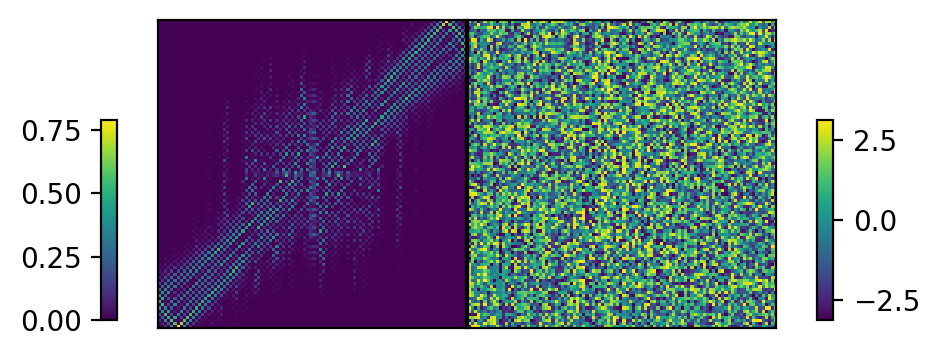

In [33]:
#this takes a few minutes
n=100; ntau=n*4;  a = 0.5; b=0; eps = 0.5; mu = 0.0; mup=mu;  
d_a = 0.0; d_b = 0.000; d_eps = 0.0; d_mu = 0.001; d_mup = d_mu
nseries=200 

parms0 = np.array([a,b,eps,mu,mup])
d_parms_period = np.array([d_a,d_b,d_eps,d_mu,d_mup])

# compute the transition matrix and eigenfunctions at beginning and end of series 
U_list,w_list,vr_list,wsort_list,vrsort_list, expsort_list, sigsort_list, U_trans_list =\
  U_prop_series(n,ntau,parms0,d_parms_period,nseries)
t_matrix,p_matrix = comp_trans(vrsort_list,  U_trans_list,nseries-1)
#plt.imshow(p_matrix)
#plt.show()
plt2_trans(t_matrix,p_matrix)

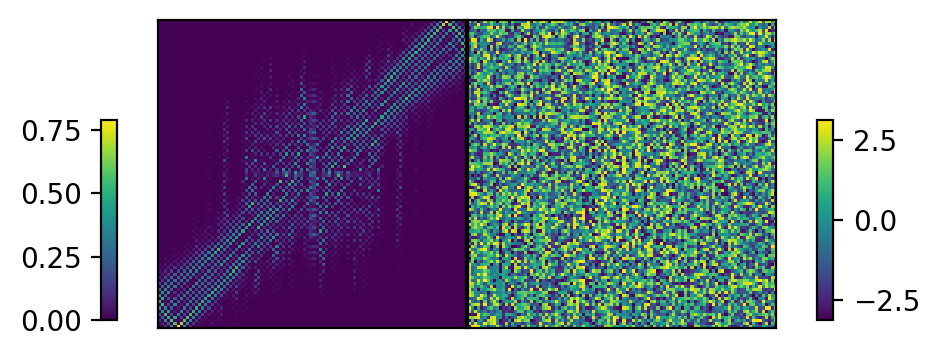

In [34]:
#this takes a few minutes
n=100; ntau=n*4;  a = 0.5; b=0; eps = 0.5; mu = 0.0; mup=mu;  
d_a = 0.0; d_b = 0.000; d_eps = 0.0; d_mu = 0.001; d_mup = d_mu
nseries=200 

parms0 = np.array([a,b,eps,mu,mup])
d_parms = np.array([d_a,d_b,d_eps,d_mu,d_mup])

# compute the transition matrix and eigenfunctions at beginning and end of series 
U_list,w_list,vr_list,wsort_list,vrsort_list, expsort_list, sigsort_list, U_trans_list =\
  U_prop_series(n,ntau,parms0,d_parms,nseries)
t_matrix,p_matrix = comp_trans(vrsort_list,  U_trans_list,nseries-1)
#plt.imshow(p_matrix)
#plt.show()
plt2_trans(t_matrix,p_matrix)

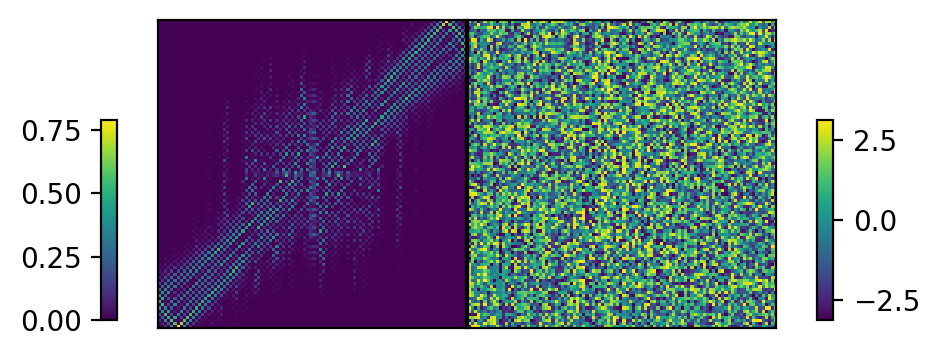

In [37]:
#this takes a few minutes
n=100; ntau=n*4;  a = 0.5; b=0; eps = 0.5; mu = 0.0; mup=mu;  
d_a = 0.0; d_b = 0.000; d_eps = 0.0; d_mu = 0.001; d_mup = d_mu
nseries=200 

parms0 = np.array([a,b,eps,mu,mup])
d_parms = np.array([d_a,d_b,d_eps,d_mu,d_mup])

# compute the transition matrix and eigenfunctions at beginning and end of series 
U_list,w_list,vr_list,wsort_list,vrsort_list, expsort_list, sigsort_list, U_trans_list =\
  U_prop_series(n,ntau,parms0,d_parms,nseries)
t_matrix,p_matrix = comp_trans(vrsort_list,  U_trans_list,nseries-1)
#plt.imshow(p_matrix)
#plt.show()
plt2_trans(t_matrix,p_matrix)

In [43]:
c_matrix_49 = Husimi.coh_Dkl_b(49)  # 

In [64]:
c_matrix_100 = Husimi.coh_Dkl_b(100)  # 

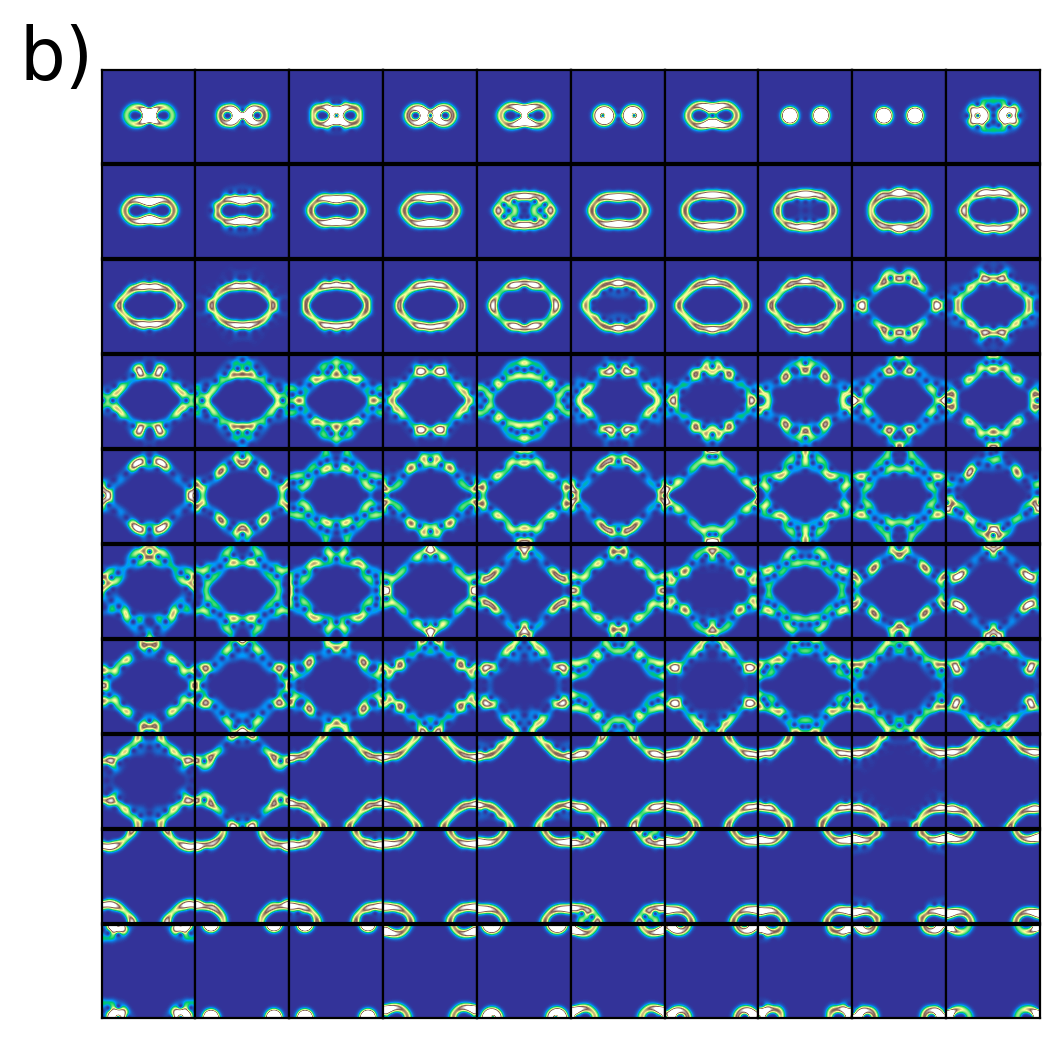

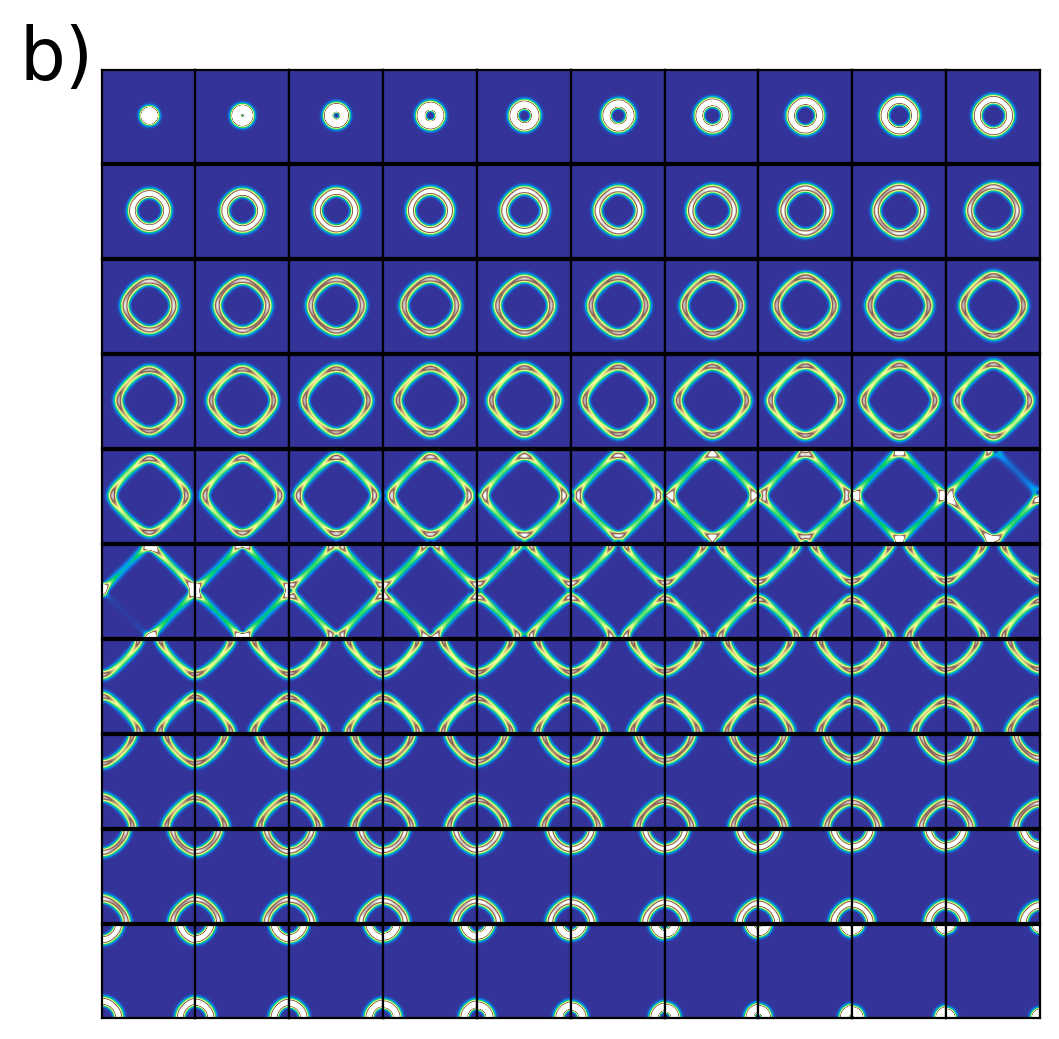

In [67]:
Hmatrix_big_last = Husimi.stor_Hus(np.squeeze(vrsort_list[-1,:,:]),c_matrix_100)
Hmatrix_big_first = Husimi.stor_Hus(np.squeeze(vrsort_list[0,:,:]),c_matrix_100)
Husimi.show_Hus(Hmatrix_big_last,'',0)
Husimi.show_Hus(Hmatrix_big_first,'',0)

In [73]:
n=100; ntau=n*4;  a = 2.5; b=0; eps = 2.5; mu = 0.0; mup=mu;  
d_a = 0.0; d_b = 0.000; d_eps = 0.0; d_mu = 0.004; d_mup = d_mu
nseries=200

parms0 = np.array([a,b,eps,mu,mup])
d_parms = np.array([d_a,d_b,d_eps,d_mu,d_mup])

# compute the transition matrix and eigenfunctions at beginning and end of series 
U_list,w_list,vr_list,wsort_list,vrsort_list, expsort_list, sigsort_list, U_trans_list =\
  U_prop_series(n,ntau,parms0,d_parms,nseries)
t_matrix,p_matrix = comp_trans(vrsort_list,  U_trans_list,100)
t_matrix2,p_matrix2 = comp_trans(vrsort_list,  U_trans_list,nseries-1)
print(nseries*d_mu)

0.8


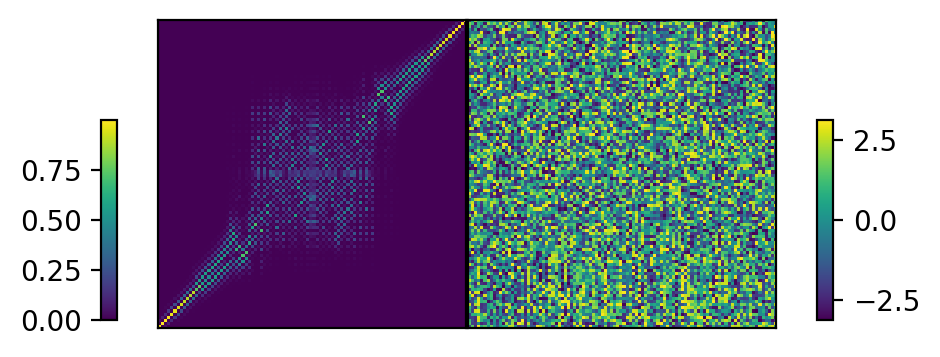

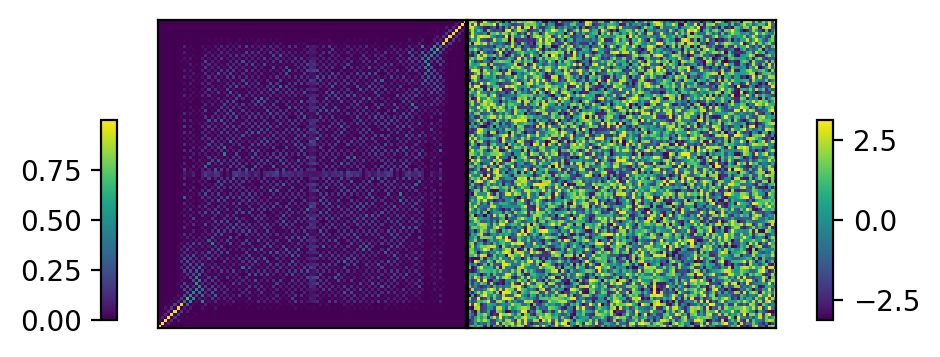

In [74]:

plt2_trans(t_matrix,p_matrix)
plt2_trans(t_matrix2,p_matrix2)

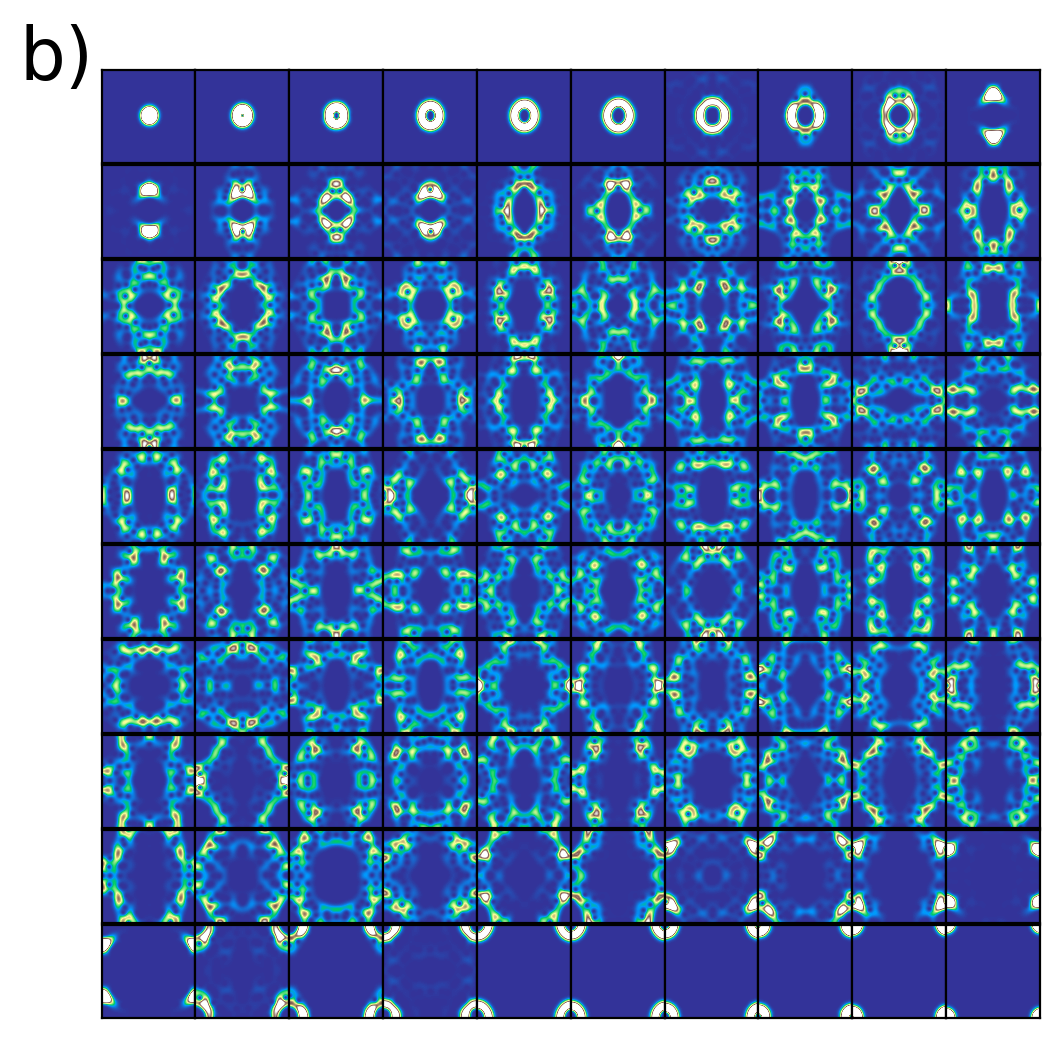

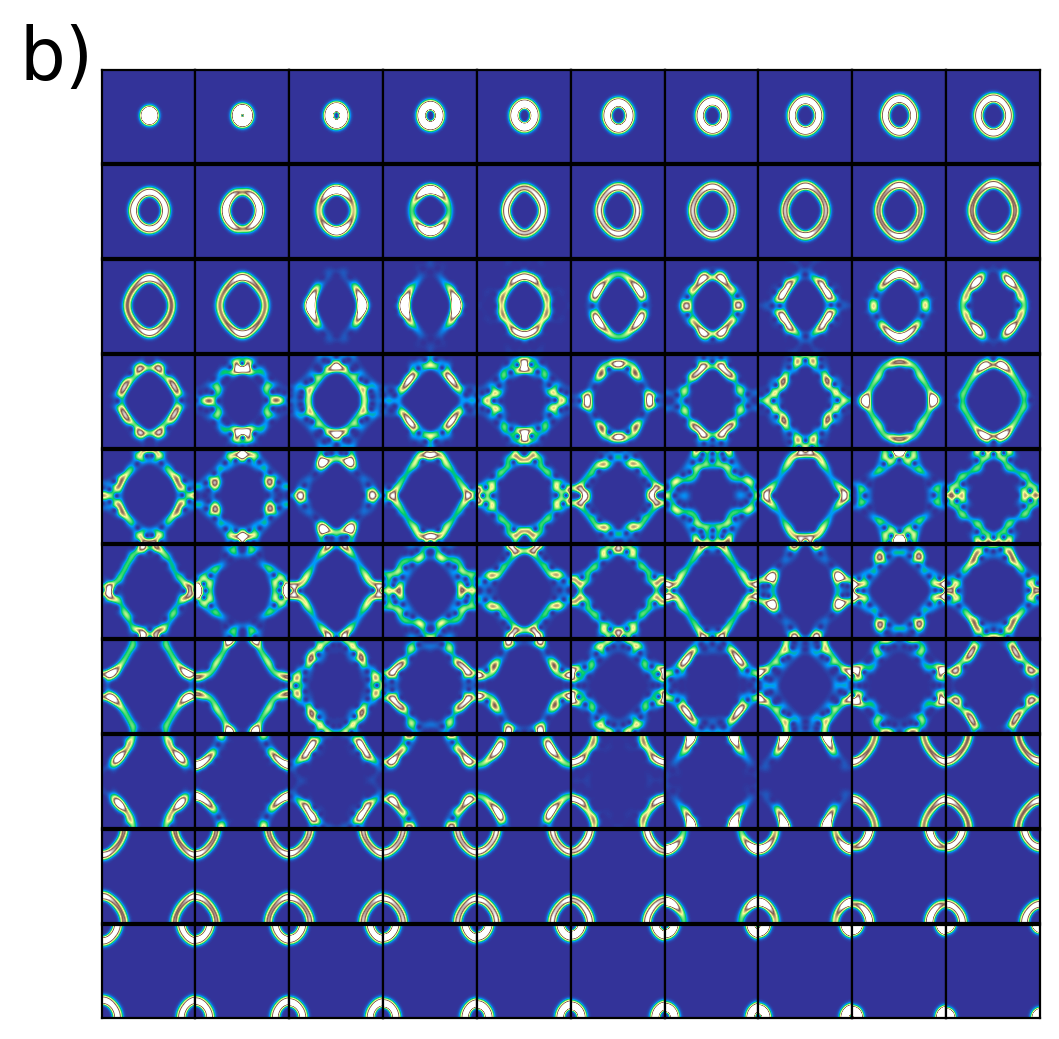

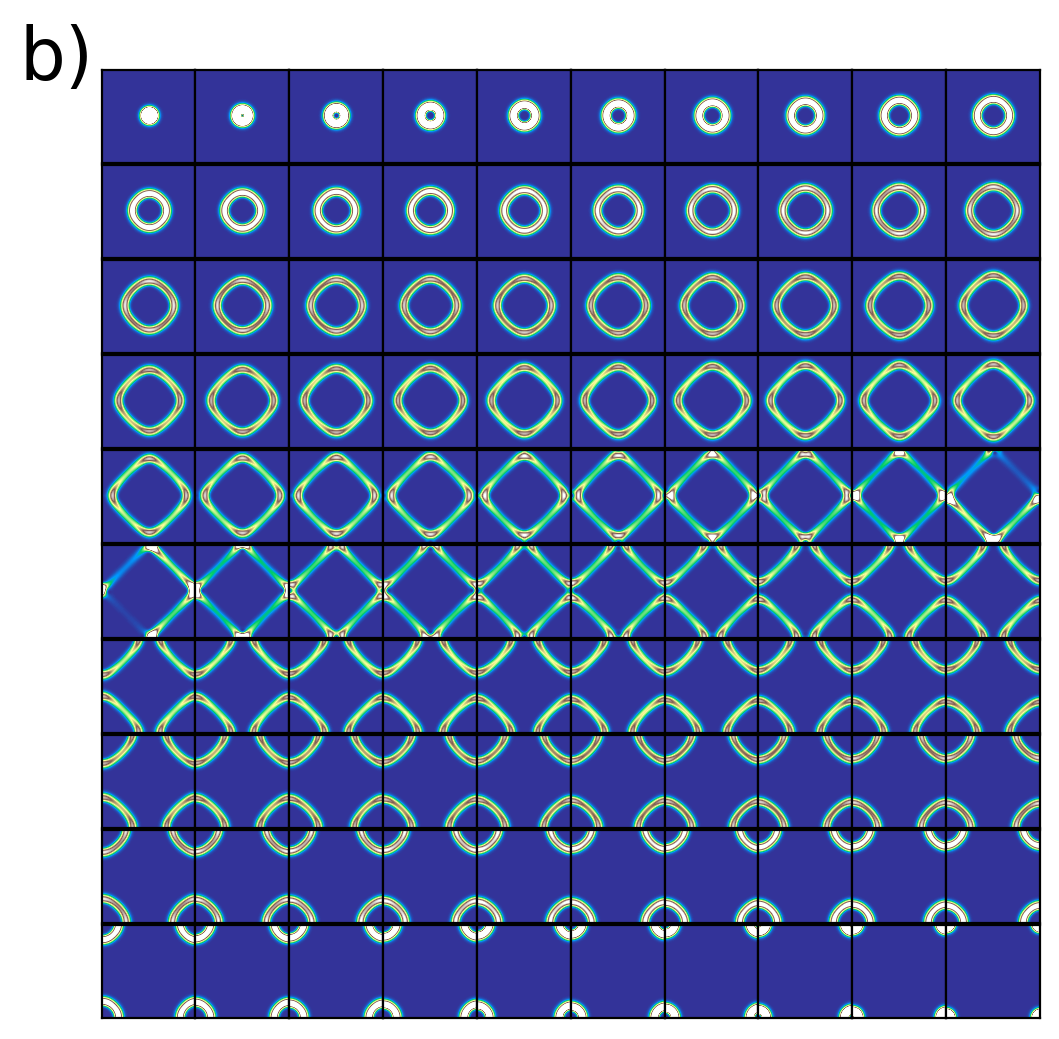

In [76]:
Hmatrix_big_last = Husimi.stor_Hus(np.squeeze(vrsort_list[-1,:,:]),c_matrix_100)
Hmatrix_big_med = Husimi.stor_Hus(np.squeeze(vrsort_list[100,:,:]),c_matrix_100)
Hmatrix_big_first = Husimi.stor_Hus(np.squeeze(vrsort_list[0,:,:]),c_matrix_100)
Husimi.show_Hus(Hmatrix_big_last,'',0)
Husimi.show_Hus(Hmatrix_big_med,'',0)
Husimi.show_Hus(Hmatrix_big_first,'',0)

In [15]:
# routines for classical drifting system integration 

# What if parameter $a,b,\epsilon,\mu, \mu_p$ all drift?

# dy/dt = func(y,t), needed for integrator!
# note that y[0] = phi and y[1] = p
def func_dr(y,tau,parms0,d_parmsdt):
    parms = parms0 + d_parmsdt*tau  # parameters drifting here 
    a = parms[0]
    b = parms[1]
    eps = parms[2]
    mu = parms[3]
    mup = parms[4]
    return [a*np.sin(y[1] - b) ,\
                -epsilon*np.sin(y[0]) - mu*np.sin(y[0] - tau) - mup*np.sin(y[0] + tau)]

# looks like I wrote a routine but did not do anything with it!

# at time tau, what is the hamilonian value?
def H_classical_dr(p,phi,tau,parms0,d_parmsdt):
    #phi = y[0]; p = y[1]
    parms = parms0 + d_parmsdt*tau  # parameters drifting here 
    a = parms[0]
    b = parms[1]
    eps = parms[2]
    mu = parms[3]
    mup = parms[4]
    return a*(1.0 - np.cos(p-b)) - epsilon*np.cos(phi)\
        - mu*np.cos(phi-tau) - mup*np.cos(phi+tau)

In [22]:
# compute coherent states in advance
c_matrix_100 = Husimi.coh_Dkl_b(100)  # 

In [13]:
c_matrix_49 = Husimi.coh_Dkl_b(49)  # 

In [15]:
# class structure to store a specific non-drifting dynamical system 
# requires c_matrix, storing coherent states to be made ahead of time
class Hsys:
    def __init__(self,n,ntau,a,b,eps,mu,mup,c_matrix):
        self.n = n
        self.ntau = ntau
        self.a = a
        self.b = b
        self.eps = eps
        self.mu = mu
        self.mup = mup
        # compute the propagator and eigenfunctions and eigenvalues
        w,vr,Up= Husimi.U_prop2(n,ntau,a,b,eps,mu,mup)
        self.w = w
        self.vr = vr
        self.Up = Up
        self.c_matrix = c_matrix
        # compute Husimi distribution
        self.Hmatrix_big = Husimi.stor_Hus(self.vr,c_matrix)
        
    def Hus(self,froot):   # show Husimi distribution
        Husimi.show_Hus(self.Hmatrix_big,froot)  
            
    def circ(self,froot):  # show stuff about eigenvalues 
        Husimi.mk_plots_circ(self.w,froot) 
        
    def classical(self,froot):  # show classical phase space 
        norb=100
        npoints=200
        Harp.mkfig_cl(norb,npoints,self.a,self.b,self.eps,self.mu,self.mup,froot)
          

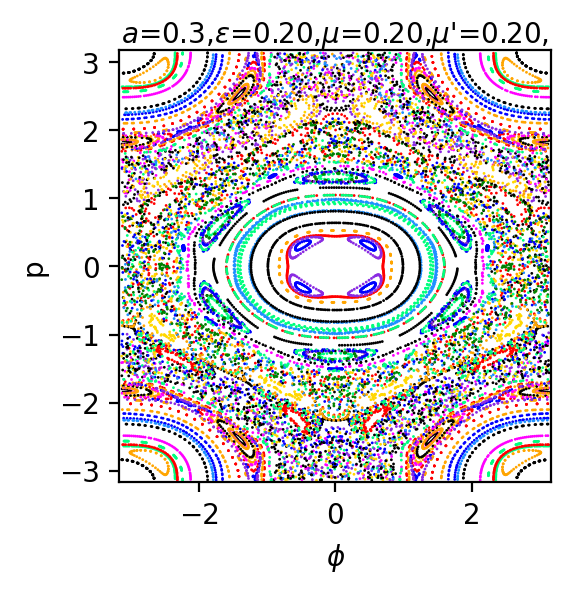

In [75]:
n=49; ntau=400; a = 0.3; b=0.0; eps = 0.2; mu = 0.2; mup=mu; 
sim2= Hsys(n,ntau,a,b,eps,mu,mup,c_matrix_49) 
froot = ''
#sim2.Hus(froot)
sim2.classical(froot)
#sim2.circ(froot)

0.2 0.04


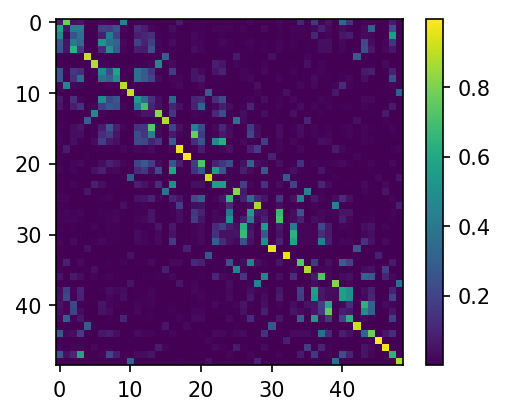

In [94]:
n=49; ntau=400;  a = 0.3; b=0; eps = 0.2; mu = 0.2; mup=mu;  
parms0 = np.array([a,b,eps,mu,mup])
d_mu = 0 # 0.0005
d_b = 0.0002
d_parms = np.array([0.0,d_b,0.0,d_mu,0.0])
nseries=200
w_list,vr_list,w_var_list,vr_var_list,Ut,t_matrix,Hmatrix_big0, Hmatrix_big1 = \
   U_prop_series(n,ntau,parms0,d_parms,nseries)
a_list = np.angle(w_list) # lists of eigenvalues phases one for each step
a_var_list = np.angle(w_var_list)  # consecutive eigenvalue phases each step of propagator
print(mu+nseries*d_mu, b+ nseries*d_b)

fig,ax = plt.subplots(1,1,figsize=(4,3),dpi=150)
im = ax.imshow(t_matrix)
plt.colorbar(im)

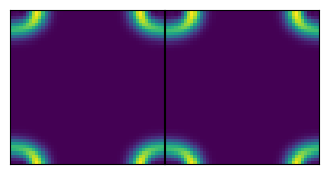

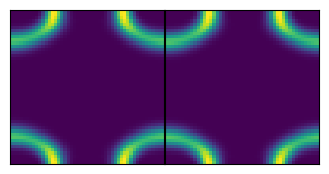

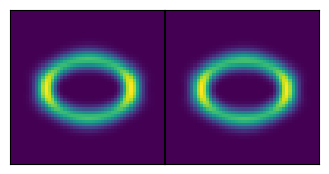

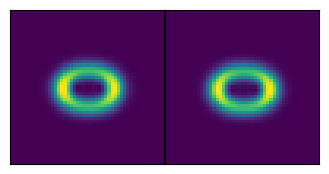

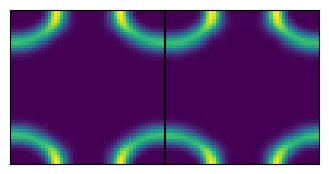

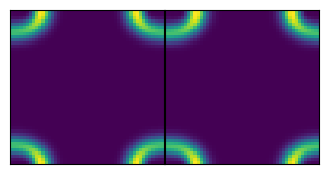

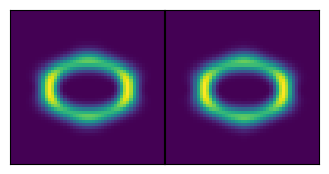

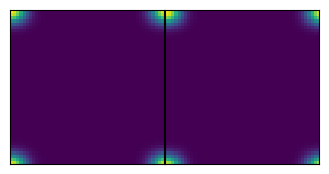

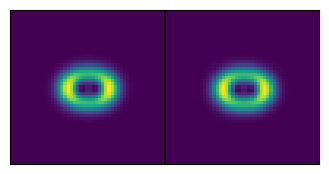

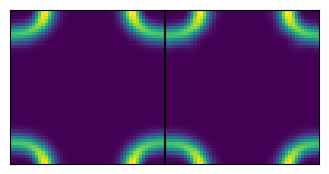

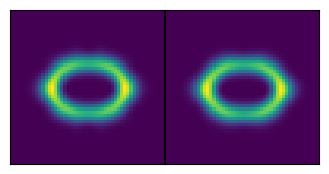

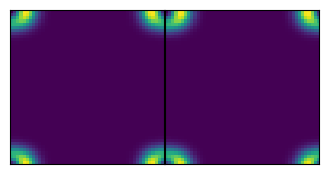

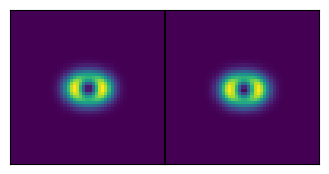

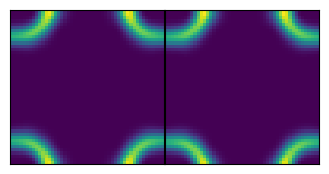

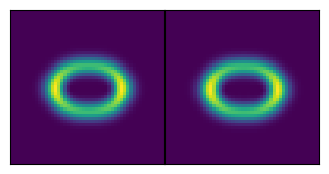

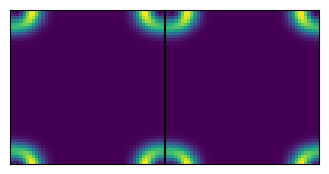

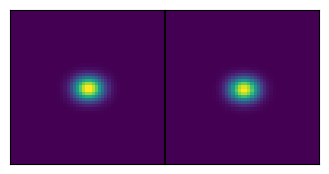

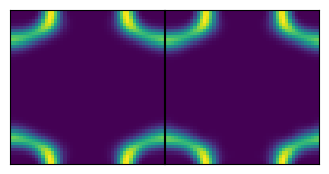

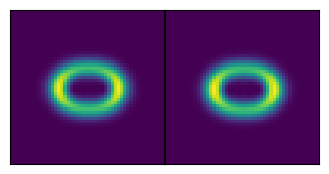

In [96]:
for i in range(n):
    for j in range(n):
        if (t_matrix[i,j]>0.8):
            plt2_H(np.squeeze(Hmatrix_big0[:,:,i]),np.squeeze(Hmatrix_big1[:,:,j]))

### periodic orbits that remain periodic orbits, evolve adiabatically
that means that energy levels never get too close to each other during adiabatic evolution
even though the system is integrable

/var/folders/l_/tk7gphlj0d38754sb6x8p1f00000gn/T/ipykernel_51046/3786354500.py:67: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axarr = plt.subplots(1,2,figsize=(4,2),sharex=True,sharey=True)


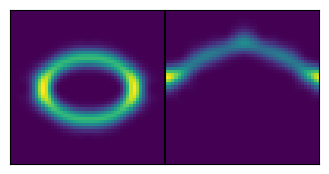

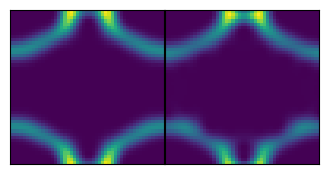

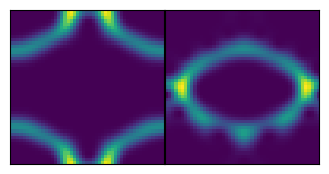

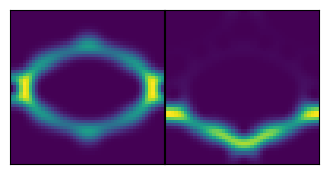

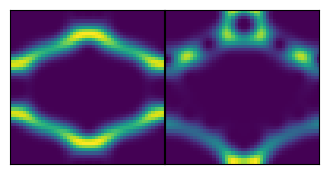

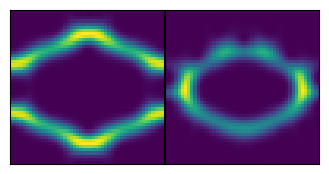

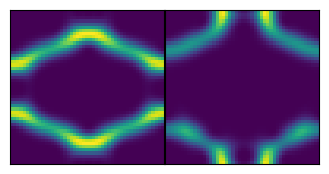

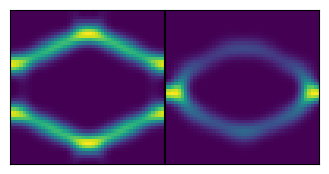

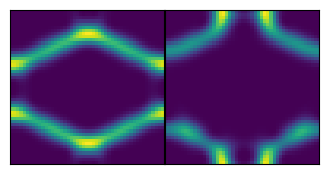

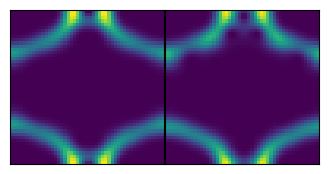

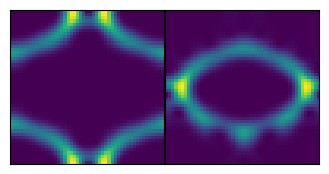

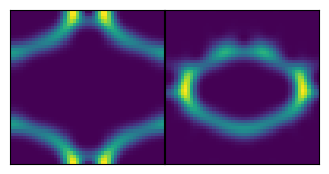

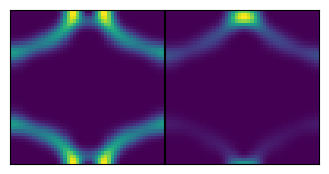

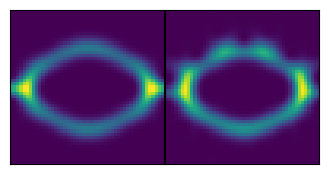

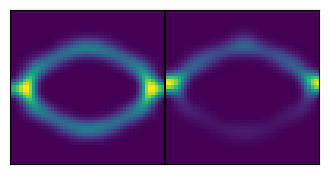

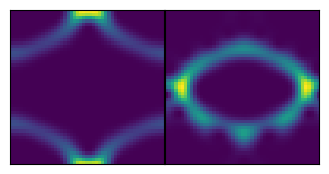

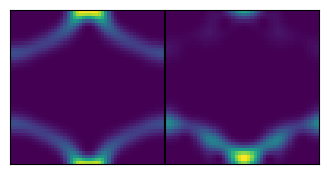

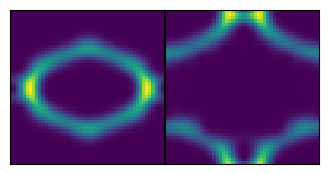

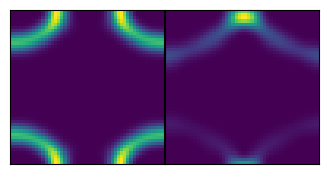

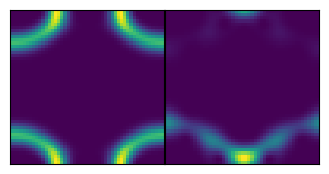

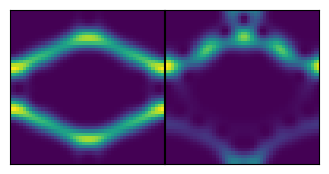

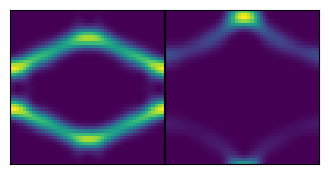

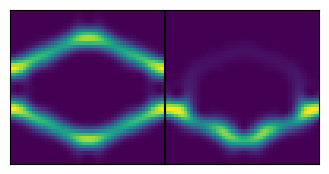

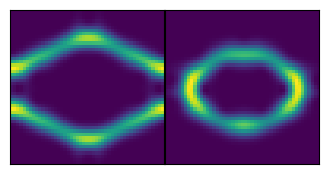

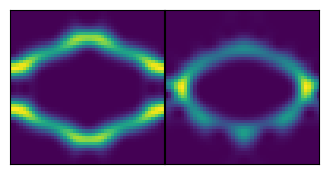

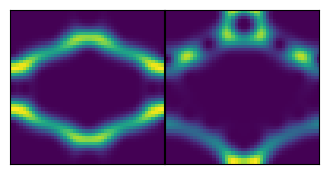

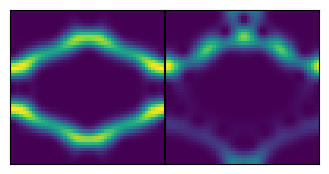

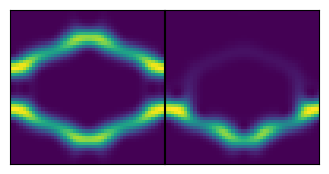

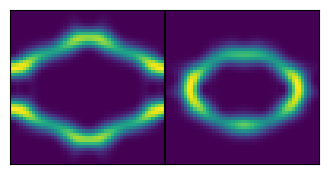

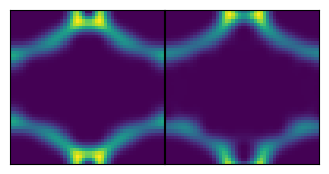

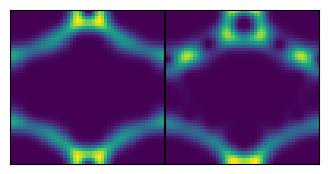

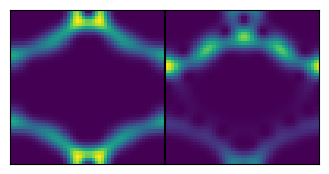

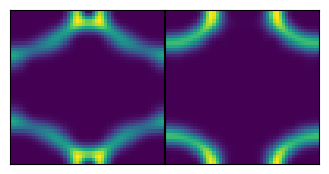

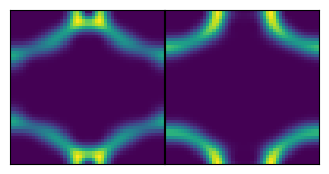

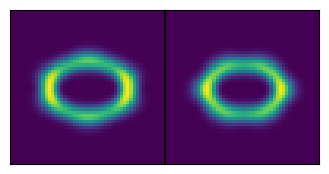

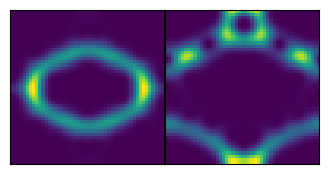

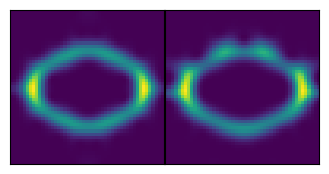

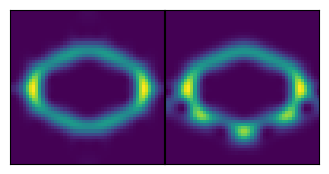

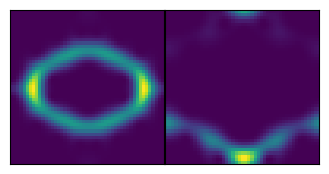

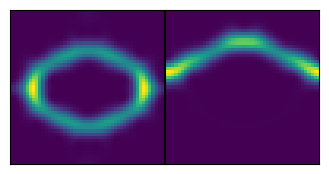

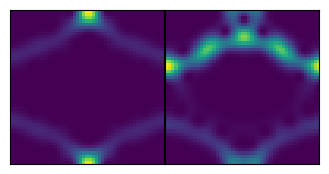

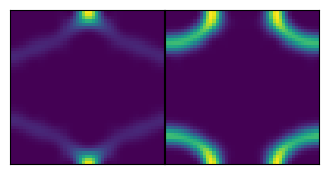

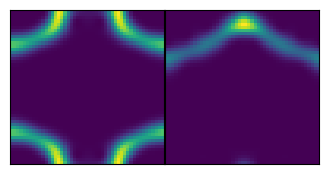

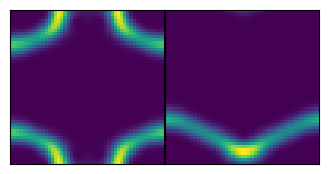

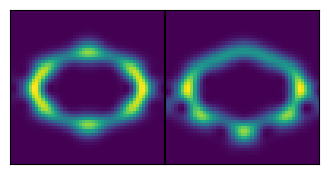

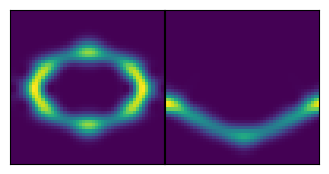

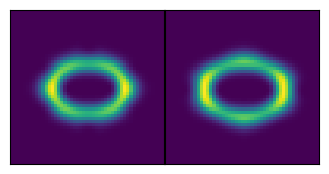

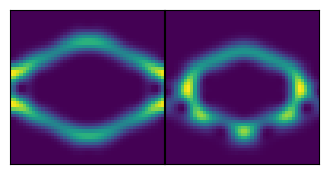

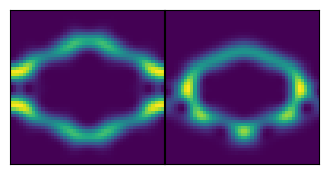

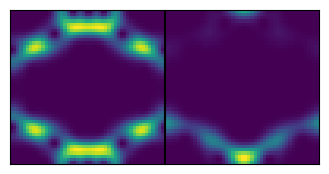

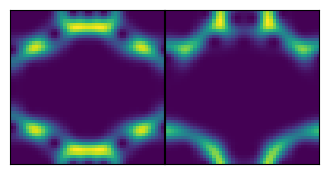

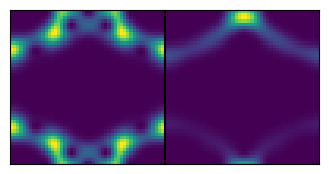

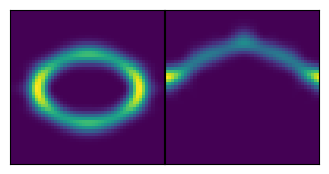

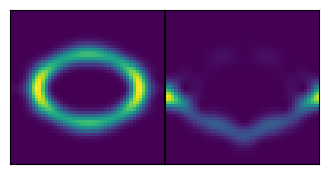

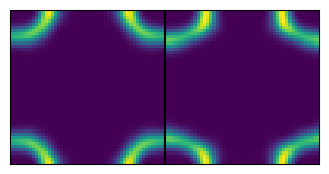

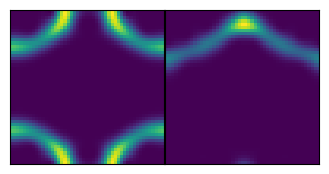

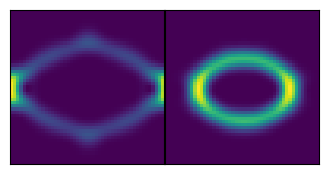

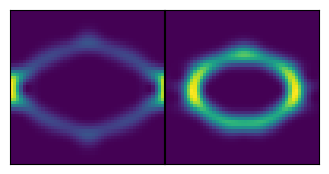

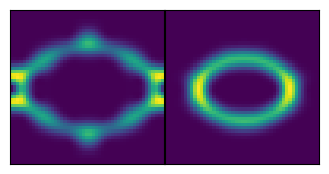

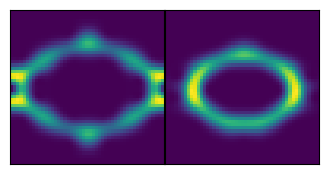

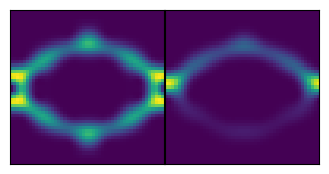

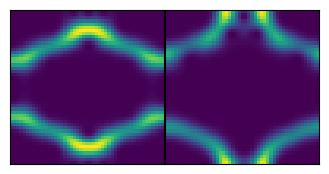

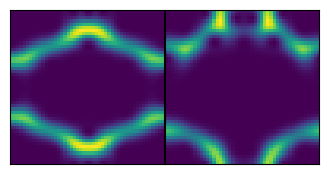

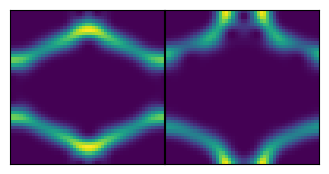

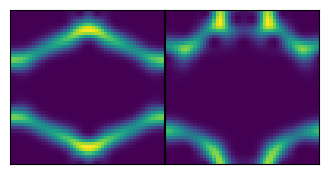

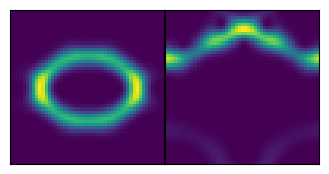

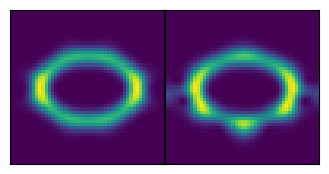

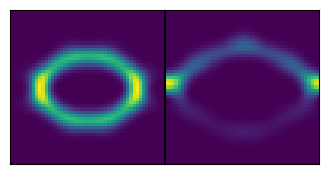

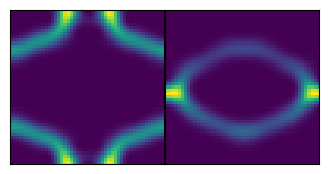

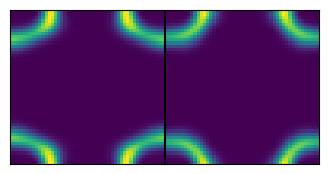

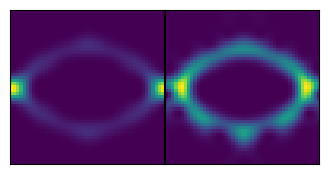

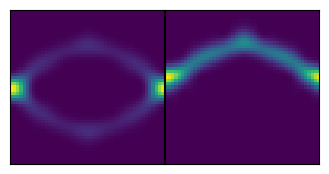

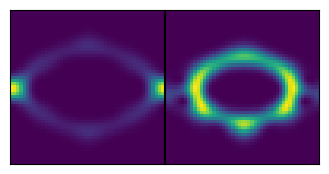

In [98]:
for i in range(n):
    for j in range(n):
        if (t_matrix[i,j]>0.15) and (t_matrix[i,j]<0.24):
            plt2_H(np.squeeze(Hmatrix_big0[:,:,i]),np.squeeze(Hmatrix_big1[:,:,j]))

### orbits near the separatrix do not evolve adiabatically 
even though that is where chaos is present
and we would think that a random matrix model describes the system
Energy levels must get close together during evolution 

What if we start as a random matrix model and only evolve from random to random?

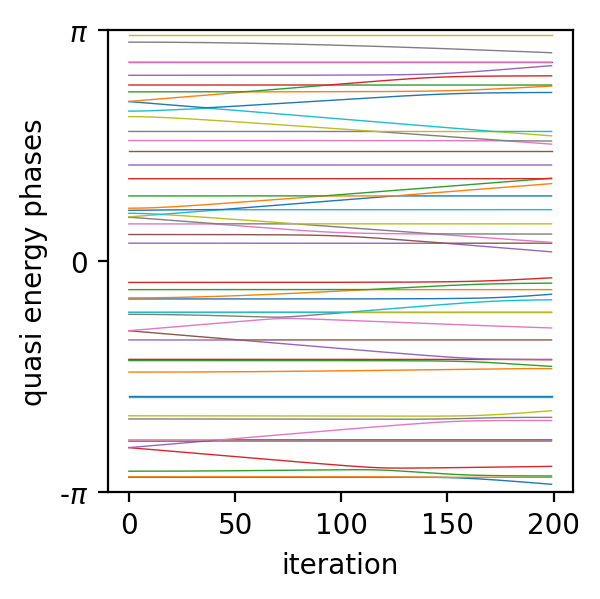

In [100]:
iis = np.arange(nseries)
fig,ax = plt.subplots(1,1,figsize=(3,3),dpi=200)
ax.set_ylim([-np.pi,np.pi])
ax.set_yticks([-np.pi,0,np.pi],labels = [r'-$\pi$','0',r'$\pi$'])
for j in range(n):
    ax.plot(iis,np.squeeze(a_list[:,j]),'-',lw=0.5)
ax.set_ylabel('quasi energy phases');
ax.set_xlabel('iteration');

# why are there any changes in quasi energies if b is drifting?  There should not be any changes?
#Hamiltonian before and after are equal except for a shift in p
# H(p,phi)before = H(p-b,phi)after
# orbits are certainty the same, except for a shift, but not sure about operators
# only a few energies seem affected 

# why?

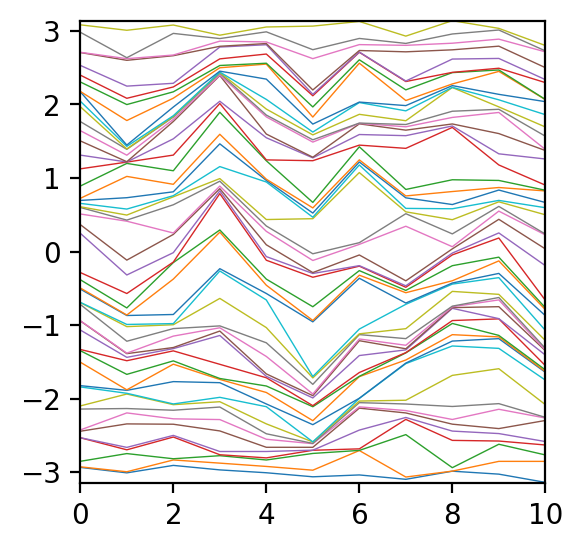

In [106]:
iis = np.arange(nseries)
fig,ax = plt.subplots(1,1,figsize=(3,3),dpi=200)
ax.set_ylim([-np.pi,np.pi])
ax.set_xlim([0,10])
for j in range(n):
    ax.plot(iis,np.squeeze(a_var_list[:,j]),'-',lw=0.5)

#absolutely not interesting energies of changing UT integrated 